The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Gráfico salvo como 'Images/WindSpeed.eps'


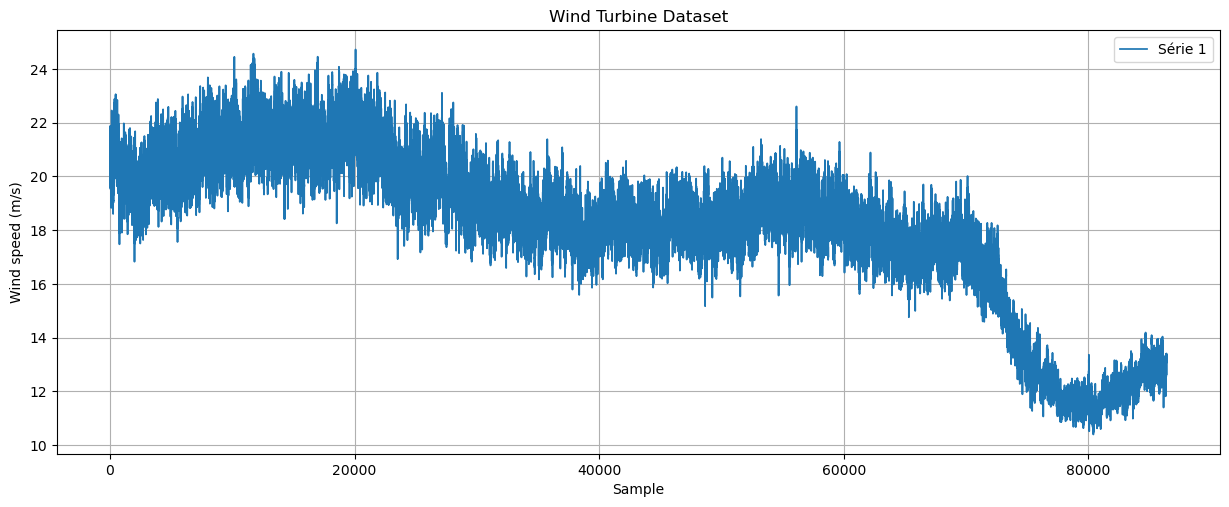

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from importlib import reload
from scipy import signal
from scipy.integrate import solve_ivp
from scipy.signal import cont2discrete, tf2ss
import math
from _GraphUtils import *


params = pd.read_csv('params1.csv')
params = dict(zip(params['Parameter'], params['Value']))

params = pd.read_csv('params1.csv')
params = dict(zip(params['Parameter'], params['Value']))

path = r'Datasets/WindSpeed_V1.csv'
df = pd.read_csv(path)  
v = df.iloc[:,0].values + 1
v = np.sqrt(np.flip(v) )*4*1.5

PlotSeries(y_arrays=[v[:]],w=15,h=5.5,yname=r'Wind speed (m/s)', xname='Sample', title='Wind Turbine Dataset',pltly=False, file_name=r'Images/WindSpeed.eps',save=True,lw=1.25)

In [46]:
def Cp_calc(LAMBDA=0, PHI=0):
    PHI = PHI*180/np.pi
    path = r'TSRxCPxPSI.csv'
    df = pd.read_csv(path)
    angles = np.arange(-5,6,1)
    TSR = df.iloc[:,0]
    diff1 = np.abs(TSR - LAMBDA)
    diff2 = np.abs(angles - PHI)
    id1 = np.argmin(diff1)
    id2 = np.argmin(diff2)+1

    return df.iloc[id1,id2]

class HAWT:
    def __init__(self, **params):

        self.Area =params['Area']
        self.B_dt =params['B_dt']
        self.B_r =params['B_r']
        self.B_g =params['B_g']
        self.CP_max =params['CP_max']
        self.ETA_dt =params['ETA_dt']
        self.ETA_gc =params['ETA_gc']
        self.f_s =params['f_s']
        self.J_r =params['J_r']
        self.J_g =params['J_g']
        self.K_dt =params['K_dt']
        self.K_opt =params['K_opt']
        self.k_i =params['k_i']
        self.k_p =params['k_p']
        self.LAMBDA_opt =params['LAMBDA_opt']
        self.N_g =params['N_g']
        self.OMEGA_n =params['OMEGA_n']
        self.OMEGA_nom =params['OMEGA_nom']
        self.OMEGA_var =params['OMEGA_var']
        self.PHI_opt = params['PHI_opt']
        self.P_r =params['P_r']
        self.PI =params['PI']
        self.R =params['R']
        self.RHO =params['RHO']
        self.T_s = params['T_s']
        self.ZETA = params['ZETA']
        

        self.X  = np.array([0,0,0])
        self.X_pitch  = np.array([0,0])
        self.dX = np.array([0,0,0]) 
        self.dX_pitch  = np.array([0,0])
        self.e = np.array([0])
        self.PHI_ref = 0 
        self.φ_ref = np.array([0]) 
        self.PHI_m = 0  
        self.φ_m = np.array([0])
        self.U = None
        self.P_g = np.array([])  
        self.P_d = np.array([]) 
        self.OMEGA_g = 0
        self.mode = np.array([])     
        self.ctrl_mode = 'mode1'

        self.ω_r = np.array([])   
        self.ω_g = np.array([])   

    def set_state(self, X):
        self.X = X.flatten()

    def TAUr_(self, ω_r, φ_m, v):
        
        λ = ω_r*self.R/v
        C_p = Cp_calc(λ, φ_m)
        τ_r = self.RHO*self.Area*C_p*(v**3)/(2*ω_r)
        #τ_r = self.RHO*self.PI*(self.R**3)*C_p*(v**2)/(2)
        self.ω_r = np.append(self.ω_r, ω_r)
        return τ_r

    def TAUg_(self, ω_g, φ_m, u_k=0):
        change = False
        
        λ = self.LAMBDA_opt + u_k
        C_p = Cp_calc(λ,φ_m)
        K_mppt = self.RHO*self.Area*(self.R**3)*C_p/(2*(λ**3))
        τ_g = K_mppt*((ω_g/self.N_g)**2)
        P_g = self.ETA_gc*ω_g*τ_g

        if self.ctrl_mode == 'mode1':
            #print('Append 1')
            self.mode = np.append(self.mode,1)
            self.K_mppt = K_mppt
            φ_ref = 0
            self.PHI_ref = 0

        if self.ctrl_mode == 'mode2':
            #print('Append 2')
            self.mode = np.append(self.mode,2)
            τ_g = self.P_r/(self.ETA_gc*ω_g)
            #P_g = self.ETA_gc*ω_g*τ_g
            #print('pg:', P_g)
            e = ω_g - self.OMEGA_nom
            φ_ref = self.φ_ref[-1] + self.k_p*e + (self.k_i*self.f_s - self.k_p)*self.e[-1]
            self.e = np.append(self.e, e)
            self.PHI_ref = φ_ref
            
        self.φ_ref = np.append(self.φ_ref, φ_ref)
        #self.P_g = np.append(self.P_g, P_g)
        #self.ω_g = np.append(self.ω_g, ω_g)

        if P_g >= self.P_r or ω_g >= self.OMEGA_nom:
            #print('change to m2')
            self.ctrl_mode = 'mode2'
            change = True

        if not change:
            if ω_g < self.OMEGA_nom - self.OMEGA_var:
                #print('change to m1')
                self.ctrl_mode = 'mode1'

        #print(P_g,self.P_r)
        #print(ω_g,self.OMEGA_nom,self.OMEGA_var)
        self.ω_g = np.append(self.ω_g, ω_g)
        self.φ_m = np.append(self.φ_m, φ_m)
        
        return τ_g
    
    
    def dynamics(self, t, X, U):

        A11 = -(self.B_dt+self.B_r)/self.J_r
        A12 = self.B_dt/(self.N_g*self.J_r)
        A13 = -self.K_dt/self.J_r
        A21 = (self.B_dt*self.ETA_dt)/(self.N_g*self.J_g)
        A22 = -(((self.B_dt*self.ETA_dt)/(self.N_g**2))+self.B_g)*(1/self.J_g)
        A23 = (self.K_dt*self.ETA_dt)/(self.N_g*self.J_g)
        A32 = -1/self.N_g
        A54 = -(self.OMEGA_n**2)
        A55 = -(2*self.ZETA*self.OMEGA_n)
        
        B11 = 1/self.J_r
        B22 = -1/self.J_g
        B53 = (self.OMEGA_n**2)
        
        A = np.array([[A11, A12, A13,   0,   0],
                      [A21, A22, A23,   0,   0],
                      [  1, A32,   0,   0,   0],
                      [  0,   0,   0,   0,   1],
                      [  0,   0,   0, A54, A55]])
        
        B = np.array([[B11,   0,   0],
                      [  0, B22,   0],
                      [  0,   0,   0],
                      [  0,   0,   0],
                      [  0,   0, B53]])
        
        T_s=1
        #I = np.eye(A.shape[0])
        #Ad = np.linalg.inv(I + 0.5 * T_s * A).dot(I - 0.5 * T_s * A)
        #Bd = np.linalg.inv(I + 0.5 * T_s * A).dot(T_s * B)

        n_states = A.shape[0]
        n_inputs = B.shape[1]
        C = np.eye(n_states)
        D = np.zeros((n_states, n_inputs))

        sys_continuous = (A, B, C, D)
        sys_discrete = signal.cont2discrete(sys_continuous, dt=T_s, method='zoh')
        
        # 4. Extract Ad and Bd
        Ad = sys_discrete[0]
        Bd = sys_discrete[1]

        dX = (Ad@X.reshape(-1,1))+(Bd@U.reshape(-1,1))
        self.dX = dX.flatten()
        return dX.flatten()
    
    def compute_input(self, X, v, u_k=0):

        ω_r, ω_g, φ_m = X[0], X[1], X[3]
        φ_ref = self.φ_ref[-1]
        
        τ_r = self.TAUr_(ω_r, φ_m, v)
        τ_g = self.TAUg_(ω_g, φ_m, u_k)
        self.U = np.array([τ_r,τ_g,φ_ref])
        return self.U
    
    def iterate(self, u, dt):
        #DOP853
        sol = solve_ivp(self.dynamics, [0, dt], self.X, 
            args=(u.flatten(),), method="RK23", t_eval=[dt])
        self.X = sol.y[:, -1]
        return self.X
    
    def iterate2(self, U, dt):
        X = self.X
        X = self.dynamics(dt,X,U)
        self.X = X
        return self.X
    
    def compute_output(self):
        ω_r, ω_g = self.X[0], self.X[1]
        τ_r, τ_g = self.U[0], self.U[1]
        η_gc = self.ETA_gc
        P_g = ω_g*η_gc*τ_g
        #print('ω_g:',ω_g)
        self.P_g = np.append(self.P_g, P_g)

    
    

In [ ]:
hawt = HAWT(**params)
X=np.array([0.1,0.1,0,0,0])
hawt.set_state(X)

e = 1000
for i,v_ in enumerate(v[:]):
    print(i,'-',X)
    U = hawt.compute_input(X,v=v_,u_k=0)
    X = hawt.iterate2(U,1) #dt=0.1
    hawt.compute_output()

0 - [0.1 0.1 0.  0.  0. ]
1 - [0.10901459 0.10992681 0.00037305 0.         0.        ]
2 - [1.18733877e-01 1.17023929e-01 4.68141989e-05 0.00000000e+00
 0.00000000e+00]
3 - [0.12446467 0.12650819 0.00018324 0.         0.        ]
4 - [0.13449139 0.13263278 0.00025885 0.         0.        ]
5 - [ 1.40222605e-01  1.41395349e-01 -2.16271591e-05  0.00000000e+00
  0.00000000e+00]
6 - [0.14766806 0.14740728 0.00035132 0.         0.        ]
7 - [ 1.54992729e-01  1.54322392e-01 -2.94619635e-05  0.00000000e+00
  0.00000000e+00]
8 - [0.16089034 0.16232676 0.00028383 0.         0.        ]
9 - [1.69032925e-01 1.67120751e-01 8.92629317e-05 0.00000000e+00
 0.00000000e+00]
10 - [1.74376710e-01 1.76408765e-01 1.38300485e-04 0.00000000e+00
 0.00000000e+00]
11 - [0.18294938 0.1812124  0.00025896 0.         0.        ]
12 - [ 1.88103566e-01  1.89136576e-01 -2.89181694e-05  0.00000000e+00
  0.00000000e+00]
13 - [0.1951749  0.1950871  0.00035762 0.         0.        ]
14 - [ 2.02414588e-01  2.01575430e-0

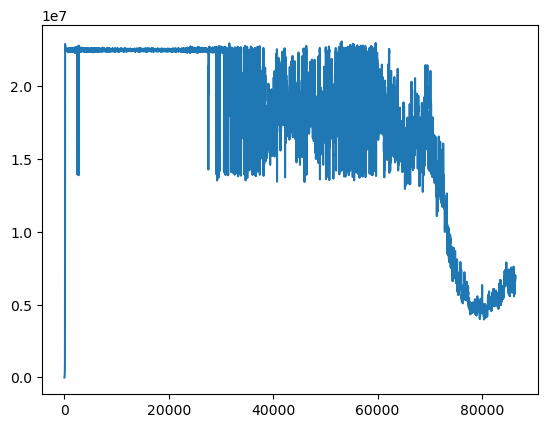

In [19]:
y = hawt.P_g[:]
x = np.arange(len(y))
y2 = np.array([hawt.P_r for i in range(len(x))])
#plt.plot(x,y2)
plt.plot(x,y)

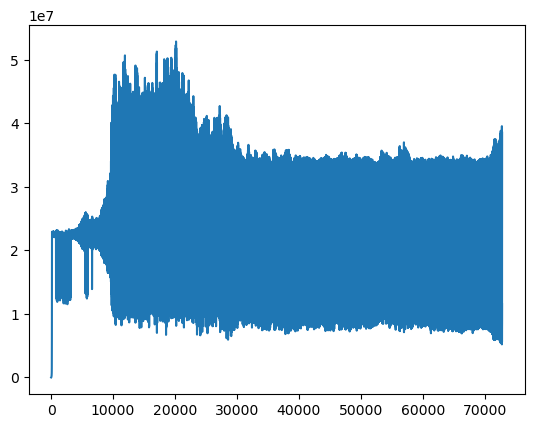

In [41]:
y = hawt.P_g[:-7000]
x = np.arange(len(y))
y2 = np.array([hawt.P_r for i in range(len(x))])
#plt.plot(x,y2)
plt.plot(x,y)

In [43]:
len(hawt.ω_g)

159580

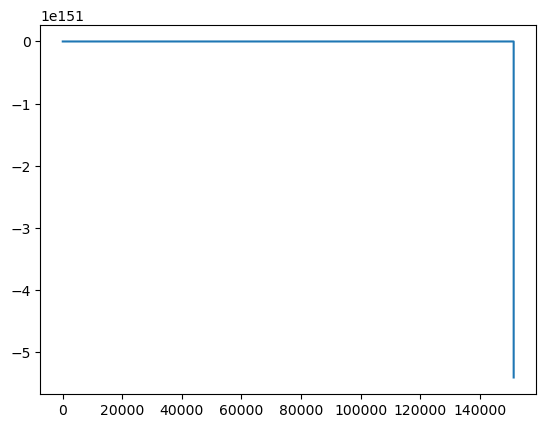

In [42]:
y = hawt.ω_g
x = np.arange(len(y))
y2 = np.array([hawt.P_r for i in range(len(x))])
#plt.plot(x,y2)
plt.plot(x,y)

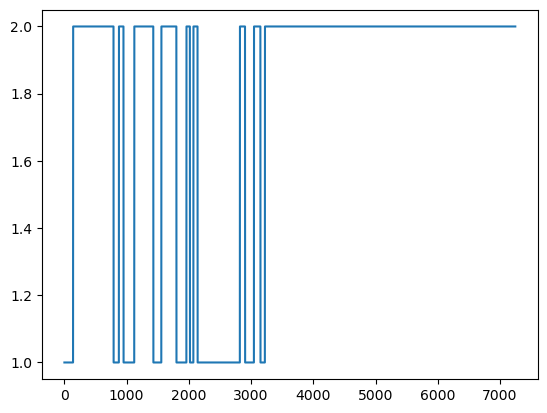

In [17]:
y = hawt.mode
x = np.arange(len(y))
y2 = np.array([hawt.OMEGA_nom for i in range(len(x))])
#plt.plot(x,y2)
plt.plot(x,y)

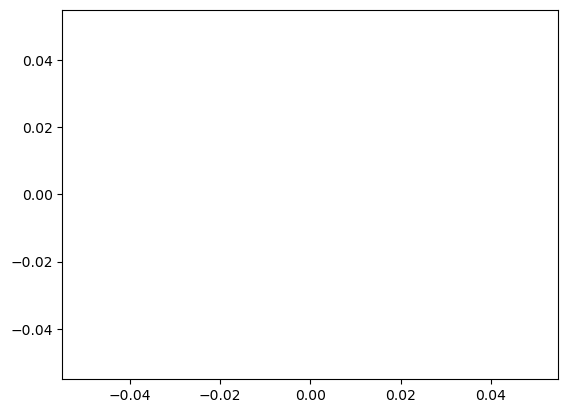

In [24]:
plt.plot(hawt.φ_m)